<a href="https://colab.research.google.com/github/gcagua/202120_Ejemplo_Parcial_Practico_1/blob/master/Lab2Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![banner.jpeg](attachment:484c3c59-fcd8-416a-bf3d-571a5fda0031.jpeg)

# Laboratorio 2 Machine Learning no supervisado, clustering (agrupamiento por similitud)

El objetivo de este notebook es mostrar cómo resolver un problema de clustering utilizando la librería Scikit-Learn. Se toma nuevamente el caso de estudio de SpotiAlpes buscando crear clusters (grupos) de canciones utilizando algoritmos como K-Means. Se revisan algunas métricas para evaluar este tipo de "modelos" y se realiza la interpretación de los clusters construidos.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

## Settings de visualización del output del notebook

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Definición de funciones utitles

In [3]:
def plot_silhouette(X, n_clusters, random_state = 0):
    for n in n_clusters:
        kmeans_ = KMeans(n_clusters = n, random_state = random_state)
        preds_ = kmeans_.fit_predict(X)

        # Se calcula el coeficiente de silueta general
        silhouette_avg = silhouette_score(X, preds_)
        print('For n_clusters =', n, ', the average silhouette score is :', silhouette_avg )

        # Se calcula el coeficiente de silueta para cada instancia
        sample_silhouette_values = silhouette_samples(X, preds_)

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n + 1) * 10])

        y_lower = 10
        for i in range(n):
            ith_cluster_silhouette_values = sample_silhouette_values[preds_ == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n)
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor = color, edgecolor = color, alpha = 0.7)
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10

        ax1.set_title('The silhouette plot for the various clusters')
        ax1.set_xlabel('The silhouette coefficient values')
        ax1.set_ylabel('Cluster label')
        ax1.axvline(x=silhouette_avg, color = 'red', linestyle = '--')
        ax1.set_yticks([])
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        colors = cm.nipy_spectral(preds_.astype(float) / n)
        ax2.scatter(X[:, 0], X[:, 1], marker = '.', s = 30, lw = 0, alpha = 0.7, c = colors, edgecolor = 'k')

        centers = kmeans_.cluster_centers_
        ax2.scatter(centers[:, 0], centers[:, 1], marker = 'o', c = 'white', alpha = 1, s = 200, edgecolor = 'k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker = '$%d$' % i, alpha = 1, s = 50, edgecolor = 'k')

        ax2.set_title('The visualization of the clustered data')
        ax2.set_xlabel('Feature space for the 1st feature')
        ax2.set_ylabel('Feature space for the 2nd feature')

        plt.suptitle('Silhouette analysis for KMeans clustering on sample data with n_clusters = %d' % n, fontsize = 14, fontweight = 'bold')

    plt.plot()
    plt.show()

## 1. Carga de los datos

In [4]:
df_companies = pd.read_csv('./data/Empresas_mas_grandes_del_pais_2018.csv', index_col = 0, delimiter=';')

FileNotFoundError: ignored

In [ ]:
df_companies.shape

(1068, 19)

## 2. Limpieza de datos

Se aplican los mismos procesos de limpieza realizados en el notebook de clasificación.

In [ ]:
df_companies.drop_duplicates(subset = 'NIT', keep = 'first', inplace = True)

In [ ]:
df_companies.isnull().sum() / df_companies.shape[0]

NIT                              0.000
RAZON SOCIAL                     0.000
SUPERVISOR                       0.000
REGIÓN                           0.001
DEPARTAMENTO DOMICILIO           0.005
CIUDAD DOMICILIO                 0.004
CIIU                             0.001
MACROSECTOR                      0.003
INGRESOS OPERACIONALES\n2018*    0.001
GANANCIA (PERDIDA) 2018          0.001
TOTAL ACTIVOS 2018               0.002
TOTAL PASIVOS 2018               0.002
TOTAL PATRIMONIO 2018            0.004
INGRESOS OPERACIONALES\n2017*    0.005
GANANCIA (PERDIDA) 2017          0.001
TOTAL ACTIVOS 2017               0.002
TOTAL PASIVOS 2017               0.000
TOTAL PATRIMONIO 2017            0.000
GRUPO EN NIIF                    0.000
dtype: float64

In [ ]:
df_companies.dtypes

NIT                                int64
RAZON SOCIAL                      object
SUPERVISOR                        object
REGIÓN                            object
DEPARTAMENTO DOMICILIO            object
CIUDAD DOMICILIO                  object
CIIU                              object
MACROSECTOR                       object
INGRESOS OPERACIONALES\n2018*     object
GANANCIA (PERDIDA) 2018           object
TOTAL ACTIVOS 2018                object
TOTAL PASIVOS 2018                object
TOTAL PATRIMONIO 2018             object
INGRESOS OPERACIONALES\n2017*     object
GANANCIA (PERDIDA) 2017          float64
TOTAL ACTIVOS 2017                object
TOTAL PASIVOS 2017                object
TOTAL PATRIMONIO 2017             object
GRUPO EN NIIF                     object
dtype: object

In [ ]:
def clean_accounting_columns(x):
    if type(x) == str:
      return x.replace(" ", "").replace("$", "").replace("E", "e").replace(",", ".")
    else:
      return x

df_companies["TOTAL PASIVOS 2017"] = df_companies["TOTAL PASIVOS 2017"].apply(clean_accounting_columns)
df_companies["INGRESOS OPERACIONALES\n2018*"] = df_companies["INGRESOS OPERACIONALES\n2018*"].apply(clean_accounting_columns)
df_companies["INGRESOS OPERACIONALES\n2017*"] = df_companies["INGRESOS OPERACIONALES\n2017*"].apply(clean_accounting_columns)

In [ ]:
# Convertir los valores en notación científica a enteros
accounting_cols = ["TOTAL ACTIVOS 2018", "TOTAL PASIVOS 2018", "TOTAL PATRIMONIO 2018", "TOTAL ACTIVOS 2017", "TOTAL PASIVOS 2017", "TOTAL PATRIMONIO 2017", "INGRESOS OPERACIONALES\n2018*", "INGRESOS OPERACIONALES\n2017*"]
for col in accounting_cols:
    if df_companies[col].dtype == object:
        df_companies[col] = df_companies[col].str.lower()
        df_companies[col] = df_companies[col].str.replace(',', '.').apply(pd.to_numeric)
    

In [ ]:
## LLenar valores de columnas de contabilidad nulas que se pueden llenar

df_companies["TOTAL ACTIVOS 2017"] = df_companies["TOTAL PASIVOS 2017"] + df_companies["TOTAL PATRIMONIO 2017"]
df_companies["TOTAL ACTIVOS 2018"] = df_companies["TOTAL PASIVOS 2018"] + df_companies["TOTAL PATRIMONIO 2018"]

df_companies["TOTAL PASIVOS 2017"] = df_companies["TOTAL ACTIVOS 2017"] - df_companies["TOTAL PATRIMONIO 2017"]
df_companies["TOTAL PASIVOS 2018"] = df_companies["TOTAL ACTIVOS 2018"] - df_companies["TOTAL PATRIMONIO 2018"]

df_companies["TOTAL PATRIMONIO 2017"] = df_companies["TOTAL ACTIVOS 2017"] - df_companies["TOTAL PASIVOS 2017"]
df_companies["TOTAL PATRIMONIO 2018"] = df_companies["TOTAL ACTIVOS 2018"] - df_companies["TOTAL PASIVOS 2018"]

In [ ]:
df_companies.dtypes

NIT                                int64
RAZON SOCIAL                      object
SUPERVISOR                        object
REGIÓN                            object
DEPARTAMENTO DOMICILIO            object
CIUDAD DOMICILIO                  object
CIIU                              object
MACROSECTOR                       object
INGRESOS OPERACIONALES\n2018*    float64
GANANCIA (PERDIDA) 2018           object
TOTAL ACTIVOS 2018               float64
TOTAL PASIVOS 2018               float64
TOTAL PATRIMONIO 2018            float64
INGRESOS OPERACIONALES\n2017*    float64
GANANCIA (PERDIDA) 2017          float64
TOTAL ACTIVOS 2017               float64
TOTAL PASIVOS 2017               float64
TOTAL PATRIMONIO 2017            float64
GRUPO EN NIIF                     object
dtype: object

In [ ]:
# Nos dimos cuenta de que hay muy poquitas regiones y existe una región de otros. Por la baja cantidad de filas con región nula, decidimos incluirlas en la categoría de otros
df_companies["REGIÓN"].value_counts()

Bogotá - Cundinamarca    555
Antioquia                161
Costa Pacífica           126
Costa Atlántica           94
Centro - Oriente          30
Eje Cafetero              22
Otros                      7
Costa Atlantica            4
Name: REGIÓN, dtype: int64

In [ ]:
def fill_null_region(x):
    if pd.isnull(x):
        return "Otros"
    else:
        return x

df_companies["REGIÓN"] = df_companies["REGIÓN"].apply(fill_null_region)

In [ ]:
def normalize_special_characters(x):
    if not pd.isnull(x):
        return x.replace("Á", "A").replace("É", "E").replace("Í", "I").replace("Ó", "O").replace("Ú", "U")

df_companies["DEPARTAMENTO DOMICILIO"] = df_companies["DEPARTAMENTO DOMICILIO"].apply(normalize_special_characters)

In [ ]:
# Se crea un diccionario para mapear los departamentos a sus regiones donde las ciudades están nulas
# En este paso se limpian las ciudades y se normalizan sus nombres
departments = {
    "AMAZONAS": "LETICIA-AMAZONAS",
    "ANTIOQUIA": "MEDELLIN-ANTIOQUIA",
    "ARAUCA": "ARAUCA-ARAUCA",
    "ATLANTICO": "BARRANQUILLA-ATLANTICO",
    "BOGOTA D.C.": "BOGOTA-D.C.-BOGOTA D.C.",
    "BOLIVAR": "CARTAGENA-BOLIVAR",
    "BOYACA": "TUNJA-BOYACA",
    "CALDAS": "MANIZALES-CALDAS",
    "CAQUETA": "FLORENCIA-CAQUETA",
    "CASANARE": "YOPAL-CASANARE",
    "CAUCA": "POPAYAN-CAUCA",
    "CESAR": "VALLEDUPAR-CESAR",
    "CHOCO": "QUIBDO-CHOCO",
    "CORDOBA": "MONTERIA-CORDOBA",
    "CUNDINAMARCA": "AGUAZUL-CUNDINAMARCA",
    "GUAINIA": "INIRIDA-GUAINIA",
    "GUAJIRA": "RIOHACHA-GUAJIRA",
    "GUAVIARE": "SAN JOSE DEL GUAVIARE-GUAVIARE",
    "HUILA": "NEIVA-HUILA",
    "MAGDALENA": "SANTA MARTA-MAGDALENA",
    "META": "VILLAVICENCIO-META",
    "NARIÑO": "PASTO-NARIÑO",
    "NORTE DE SANTANDER": "CUCUTA-NORTE DE SANTANDER",
    "PUTUMAYO": "MOCOA-PUTUMAYO",
    "QUINDIO": "ARMENIA-QUINDIO",
    "RISARALDA": "PEREIRA-RISARALDA",
    "SAN ANDRES Y PROVIDENCIA": "SAN ANDRES-SAN ANDRES",
    "SANTANDER": "BUCARAMANGA-SANTANDER",
    "SUCRE": "SINCELEJO-SUCRE",
    "TOLIMA": "IBAGUE-TOLIMA",
    "VALLE": "CALI-VALLE",
    "VAUPES": "MITU-VAUPES",
    "VICHADA": "PUERTO CARREÑO-VICHADA",
}

def fill_null_city(depto, ciudad):
    if pd.isnull(ciudad) and not pd.isnull(depto):
        return departments[depto]
    else:
        return ciudad

def complete_city(x):
    for i in departments.values():
        if x in i:
            return i
    return x

df_companies["CIUDAD DOMICILIO"] = df_companies.apply(lambda x: fill_null_city(x["DEPARTAMENTO DOMICILIO"], x["CIUDAD DOMICILIO"]), axis=1)
df_companies["CIUDAD DOMICILIO"] = df_companies["CIUDAD DOMICILIO"].apply(complete_city)

In [ ]:
# Al analizar las tablas, nos dimos cuenta de que ciudad es un atributo mucho más específico que departamento, por lo que decidimos eliminar dicha columna
df_companies.drop(columns = ["DEPARTAMENTO DOMICILIO"], inplace = True)

In [ ]:
# Los valores con nulos restantes de las columnas contables (ACTIVOS, PASIVOS y PATRIMONIOS) les hacía falta un término para poder completar la ecuación. 
# Por lo tanto, para evitar decisiones de agrupamiento erróneas decidimos eliminar dichas filas
df_companies.dropna(subset = (["TOTAL ACTIVOS 2018", "TOTAL ACTIVOS 2017", "TOTAL PASIVOS 2018", "TOTAL PASIVOS 2017", "TOTAL PATRIMONIO 2018", "TOTAL PATRIMONIO 2017"]), inplace = True)

In [ ]:
# Debido a que el CIIU es demasiado importante y específico de cada empresa, decidimos eliminar las filas con nulos en dicha columna
df_companies.dropna(subset = ["CIIU", "MACROSECTOR"], inplace = True)

In [ ]:
# Nos dimos cuenta de que hay valores del Pérdidas y Ganancias de las empresas que aparecen en nulos, debido a que no tenemos acceso al resto de los datos de dichas empresas
# Decidimos eliminar dichas filas

df_companies.dropna(subset= ["INGRESOS OPERACIONALES\n2018*", "INGRESOS OPERACIONALES\n2017*", "GANANCIA (PERDIDA) 2018", "GANANCIA (PERDIDA) 2017"], inplace = True)

In [ ]:
df_companies.isnull().sum() / df_companies.shape[0]

NIT                              0.0
RAZON SOCIAL                     0.0
SUPERVISOR                       0.0
REGIÓN                           0.0
CIUDAD DOMICILIO                 0.0
CIIU                             0.0
MACROSECTOR                      0.0
INGRESOS OPERACIONALES\n2018*    0.0
GANANCIA (PERDIDA) 2018          0.0
TOTAL ACTIVOS 2018               0.0
TOTAL PASIVOS 2018               0.0
TOTAL PATRIMONIO 2018            0.0
INGRESOS OPERACIONALES\n2017*    0.0
GANANCIA (PERDIDA) 2017          0.0
TOTAL ACTIVOS 2017               0.0
TOTAL PASIVOS 2017               0.0
TOTAL PATRIMONIO 2017            0.0
GRUPO EN NIIF                    0.0
dtype: float64

In [ ]:
df_companies.shape

(981, 18)

In [ ]:
# Después de esto normalizamos los valores monetarios, aplicando una escala logarítmica de base e

In [ ]:
def normalize_money_cols(cols):
  for col in cols:
    col_name = col + " Normalizado"
    df_companies[col_name] = df_companies[col].apply(lambda x: stats.percentileofscore(df_companies[col], x))

normalize_money_cols(["INGRESOS OPERACIONALES\n2018*", "INGRESOS OPERACIONALES\n2017*", "TOTAL ACTIVOS 2018", "TOTAL ACTIVOS 2017", "TOTAL PASIVOS 2018", "TOTAL PASIVOS 2017", "TOTAL PATRIMONIO 2018", "TOTAL PATRIMONIO 2017"])

In [ ]:
# Limpieza y normalización de MACROSECTOR
sectors = df_companies["MACROSECTOR"].value_counts().iteritems()
sector_dict = dict()
counter = 1
for sector, value in sectors:
  if sector not in sector_dict.keys():
    sector_dict[sector] = counter
    counter += 1

df_companies["MACROSECTOR"] = df_companies["MACROSECTOR"].apply(lambda x : sector_dict[x])

In [ ]:
df_companies.head()

,NIT,RAZON SOCIAL,SUPERVISOR,REGIÓN,CIUDAD DOMICILIO,CIIU,MACROSECTOR,INGRESOS OPERACIONALES\n2018*,GANANCIA (PERDIDA) 2018,TOTAL ACTIVOS 2018,TOTAL PASIVOS 2018,TOTAL PATRIMONIO 2018,INGRESOS OPERACIONALES\n2017*,GANANCIA (PERDIDA) 2017,TOTAL ACTIVOS 2017,TOTAL PASIVOS 2017,TOTAL PATRIMONIO 2017,GRUPO EN NIIF,INGRESOS OPERACIONALES\n2018* Normalizado,INGRESOS OPERACIONALES\n2017* Normalizado,TOTAL ACTIVOS 2018 Normalizado,TOTAL ACTIVOS 2017 Normalizado,TOTAL PASIVOS 2018 Normalizado,TOTAL PASIVOS 2017 Normalizado,TOTAL PATRIMONIO 2018 Normalizado,TOTAL PATRIMONIO 2017 Normalizado
No.,,,,,,,,,,,,,,,,,,,,,,,,,,
1,860003563,ABB LTDA,SUPERSOCIEDADES,Bogotá - Cundinamarca,BOGOTA-D.C.-BOGOTA D.C.,"C2711 - Fabricación de motores, generadores y ...",1,3.571775e+09,-58725480,2.956848e+09,2.476739e+09,4.801089e+08,4.005049e+09,-8.752900e+07,2.875460e+09,2.341172e+09,5.342871e+08,NIIF PLENAS-GRUPO 1,58.715596,66.972477,55.045872,58.103976,67.278287,69.826707,34.250765,39.653415
2,900138670,C.I BIOCOSTA S.A,SUPERSOCIEDADES,Costa Atlántica,SANTA-MARTA-MAGDALENA,G4610 - Comercio al por mayor a cambio de una ...,2,6.018902e+09,35049440,1.207011e+09,1.031424e+09,1.755873e+08,4.994552e+09,1.083777e+07,1.020832e+09,8.949865e+08,1.258455e+08,NIIF PLENAS-GRUPO 1,73.802243,73.700306,23.751274,22.833843,39.143731,38.939857,16.207951,14.169215
3,890302629,CONSTRUCTORA MELENDEZ S.A.,SUPERSOCIEDADES,Costa Pacífica,CALI-VALLE,F4111 - Construcción de edificios residenciales,4,1.739284e+09,17351050,3.030767e+09,2.163544e+09,8.672231e+08,1.039942e+09,-3.877247e+07,2.615650e+09,1.748991e+09,8.666590e+08,NIIF PLENAS-GRUPO 1,22.324159,5.402650,55.861366,55.045872,64.424057,62.487258,49.541284,52.701325
4,811004055,EMDISALUD,SUPERSALUD,Costa Atlántica,MONTERIA-CORDOBA,O8430- Actividades de planes de seguridad soci...,3,4.033887e+10,-30165816569,9.908133e+09,4.950861e+10,-3.960047e+10,3.696528e+10,-1.086227e+10,9.807867e+09,1.924663e+10,-9.438767e+09,NIIF PYMES-GRUPO 2,95.820591,96.024465,82.670744,84.301733,97.145770,94.801223,0.713558,0.917431
5,890503314,CERAMICA ITALIA SA,SUPERSOCIEDADES,Centro - Oriente,CUCUTA-NORTE DE SANTANDER,C2392 - Fabricación de materiales de arcilla p...,1,1.419514e+09,4582130,1.498588e+09,4.971313e+08,1.001457e+09,1.360935e+09,3.250460e+07,1.509246e+09,4.902009e+08,1.019045e+09,NIIF PYMES-GRUPO 2,5.402650,13.965341,31.600408,35.983690,14.678899,19.266055,53.516820,57.186544


## 3. Selección de atributos / features para el clustering

En una primera instancia, se escogen pocos atributos lo más interpretables posible.

In [ ]:
#features = ["TOTAL ACTIVOS 2017", "TOTAL ACTIVOS 2018", "INGRESOS OPERACIONALES\r\n2018*", "INGRESOS OPERACIONALES\r\n2017*"]
features = ["MACROSECTOR", "TOTAL ACTIVOS 2017 Normalizado", "TOTAL ACTIVOS 2018 Normalizado"]

## 5. Construcción de un primer "modelo" de clustering

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(df_companies[features])

In [ ]:
kmeans = KMeans(random_state = 0)

In [ ]:
kmeans_preds = kmeans.fit_predict(X)

In [ ]:
kmeans.n_iter_

16

In [ ]:
pd.Series(kmeans_preds).value_counts()

2    186
0    182
3    152
7    151
1    119
6     89
4     76
5     26
dtype: int64

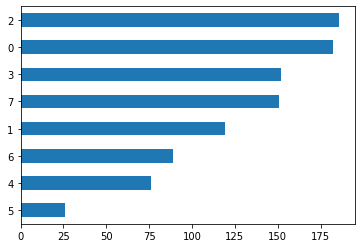

In [ ]:
pd.Series(kmeans_preds).value_counts().sort_values().plot.barh()

## 5.1 Variando la cantidad de clusters a construir
¿Qué tan diferentes son los resultados al variar la cantidad de clusters?

In [ ]:
# Se construiran 5 "modelos" de clustering con los siguientes tamaños de K
n_clusters = [2, 4, 6, 8, 10]

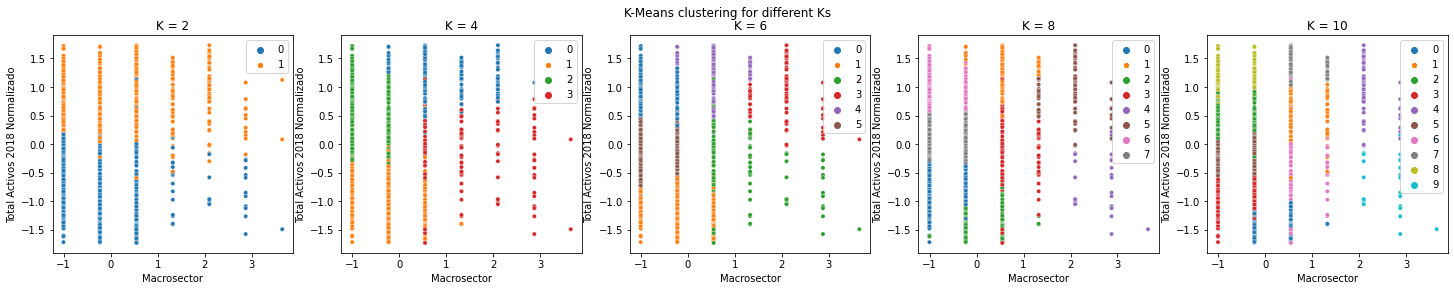

In [ ]:
fig, axes = plt.subplots(1, 5, figsize = (25, 4))
fig.suptitle('K-Means clustering for different Ks')

i = 0
for n in n_clusters:
    kmeans_ = KMeans(n_clusters = n, random_state = 1)
    
    sns.scatterplot(x = X[:,0], y = X[:,1], hue = kmeans_.fit_predict(X), palette = 'tab10', size = 1, ax = axes[i])
    axes[i].set_title('K = {}'.format(n))
    axes[i].set_xlabel('Macrosector')
    axes[i].set_ylabel('Total Activos 2018 Normalizado')
    i += 1 

¿Cómo saber la cantidad de clusters (K) a elegir? Hay 3 posibles respuestas a estas preguntas.
1. Dependiendo de la necesidad del negocio. Hay contextos en donde de alguna forma se exige a priori que se construya una cantidad dada de clusters.
2. Mediante validación cuantitativa, aplciando los métodos del codo y el coeficiente de silueta.
3. Mediante validación cualitativa, revisando la consistencia de los clusters en términos de las features utilizadas para su construcción pero también en términos de otras variables externas.

## 5.2. Validación cuantitativa: Método del codo

Este método está basado en un concepto conocido como **inercia** entendido como la distancia media al cuadrado entre cada instancia y su centroide más cercano. Algortimos como K-Means tienen como objetivo minimizar la inercia. A medida que se aumenta la cantidad de clusters (K) la inercia disminuye.  
  
Con el método del codo se busca visualmente identificar el valor de K que produce una inercia razonable y para el que un valor mayor no podrudcirá un decremento significativo adicional. Dicho en otros términos, el valor óptimo de K podría ser aquel para el que la pendiente de la curva, como se muestra abajo, tiende a aplanarse.

In [ ]:
n_clusters = range(2, 31)

In [ ]:
kmeans_inertias = []

for n in n_clusters:
    kmeans_ = KMeans(n_clusters = n, random_state = 2)
    kmeans_.fit(X)
    kmeans_inertias.append(kmeans_.inertia_)

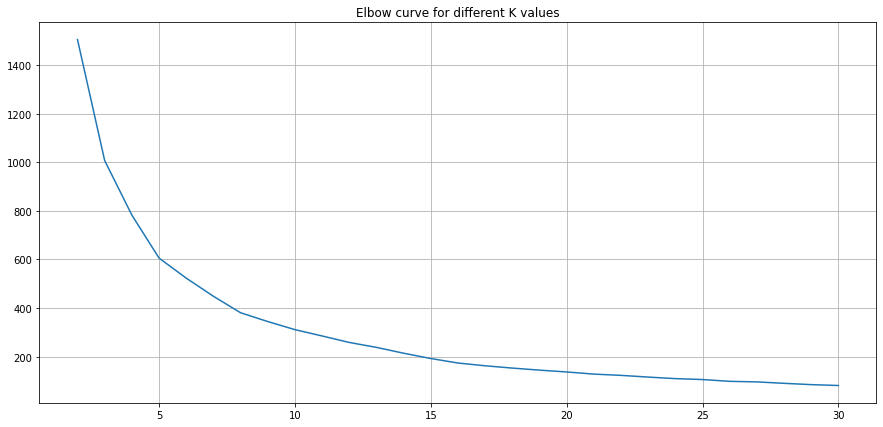

In [ ]:
fig = plt.figure(figsize = (15, 7))
plt.plot(n_clusters, kmeans_inertias)
plt.title('Elbow curve for different K values')
plt.grid(True)
plt.show()

Es dificil ver un valor de K relativamente pequeño a partir del cual la pendiente de la curva se vuelve casi plana. No es muy común encontrar contextos de negocio en donde sea aceptable construir más de 10 clusters.  
  
El principal problema de este método es que es **subjetivo**.

## 5.3. Validación cuantitativa: Método de la silueta

El método de la silueta puede ser usado para analizar la **distancia de separación entre los clusters** resultantes. Es una medida que indica que tan cerca cada instancia en un cluster está a instancias del cluster más cercano.  Es una medida que varia desde -1 a 1.  
  
El coeficiente de silueta para cada instancia es calculado como `(b - a) / max(a, b)`, en donde `a` es el promedio de la distancia intra-cluster y `b` es el promedio de la distancia al cluster más cercano. El coeficiente general se calcula con el promedio del coeficiente de silueta de cada instancia.

In [ ]:
n_clusters = [2, 4, 6, 8, 10]

For n_clusters = 2 , the average silhouette score is : 0.4344181286745651
For n_clusters = 4 , the average silhouette score is : 0.426122796788578
For n_clusters = 6 , the average silhouette score is : 0.40721338077836317
For n_clusters = 8 , the average silhouette score is : 0.386656992795711
For n_clusters = 10 , the average silhouette score is : 0.410033875943507


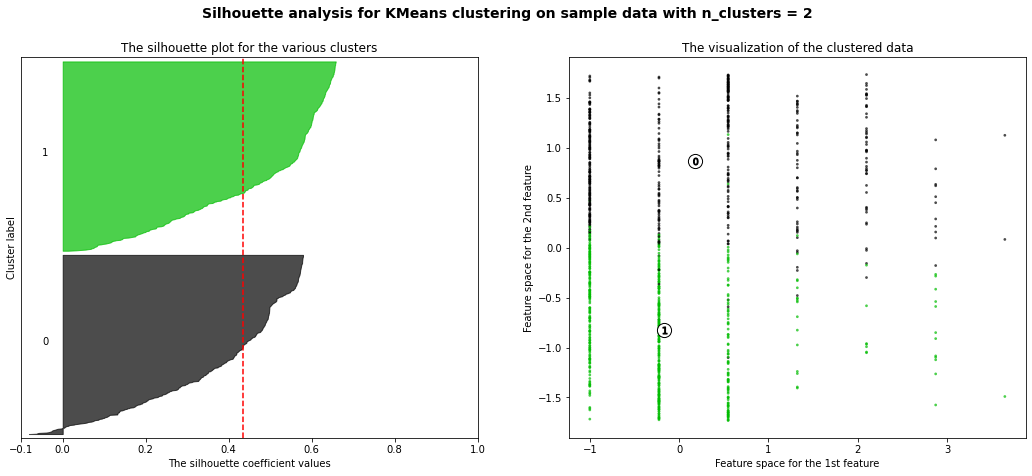

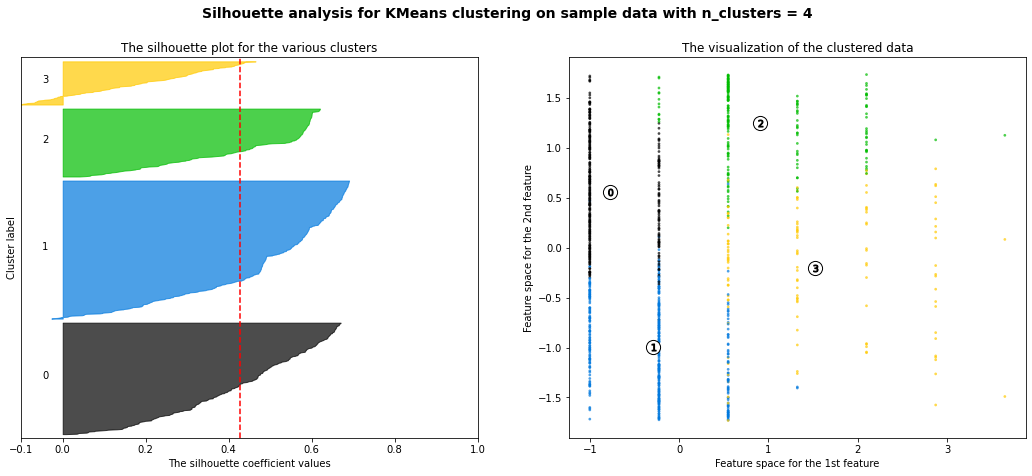

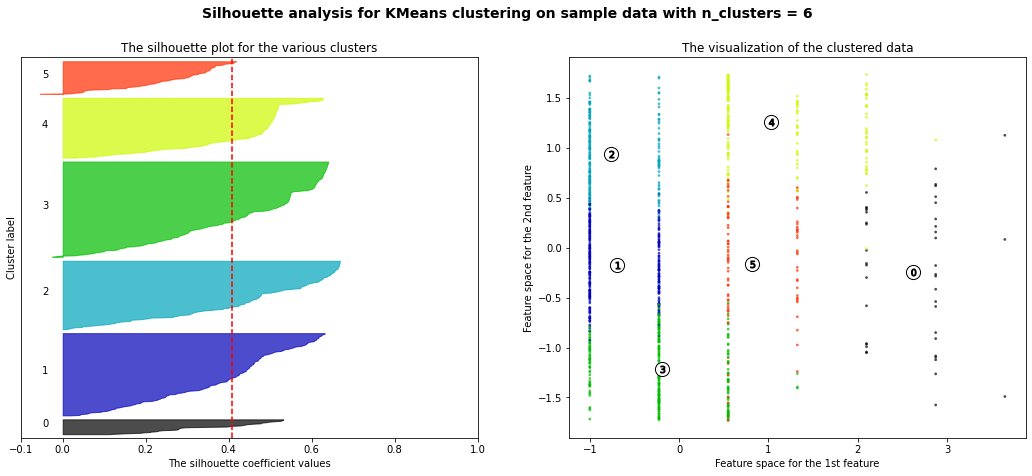

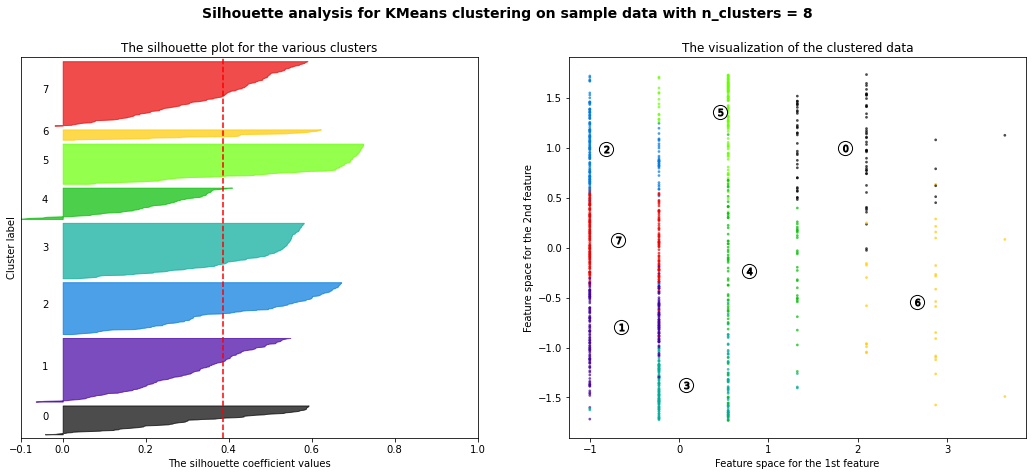

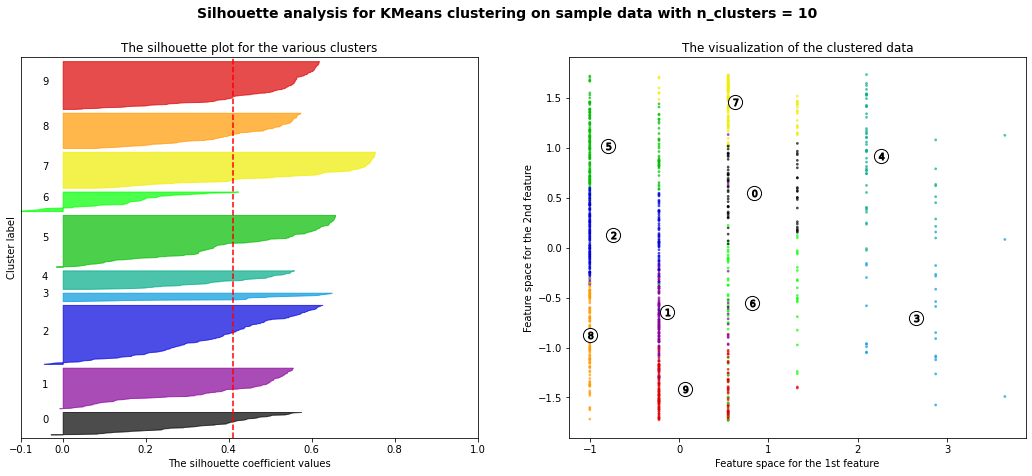

In [ ]:
plot_silhouette(X, n_clusters, random_state = 3)

Si bien este método es cuantitativo, la anterior visualización también permite distinguir homogeneidad en los clusters.

## 5.4. Inclyendo todas los atributos numéricas disponibles

In [ ]:
# Se seleccionan automáticamente todos los atributos numéricos
features = ['MACROSECTOR',
       'INGRESOS OPERACIONALES\n2018* Normalizado',
       'INGRESOS OPERACIONALES\n2017* Normalizado',
       'TOTAL ACTIVOS 2018 Normalizado', 'TOTAL ACTIVOS 2017 Normalizado',
       'TOTAL PASIVOS 2018 Normalizado', 'TOTAL PASIVOS 2017 Normalizado',
       'TOTAL PATRIMONIO 2018 Normalizado',
       'TOTAL PATRIMONIO 2017 Normalizado']

In [ ]:
features

['MACROSECTOR',
 'INGRESOS OPERACIONALES\n2018* Normalizado',
 'INGRESOS OPERACIONALES\n2017* Normalizado',
 'TOTAL ACTIVOS 2018 Normalizado',
 'TOTAL ACTIVOS 2017 Normalizado',
 'TOTAL PASIVOS 2018 Normalizado',
 'TOTAL PASIVOS 2017 Normalizado',
 'TOTAL PATRIMONIO 2018 Normalizado',
 'TOTAL PATRIMONIO 2017 Normalizado']

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(df_companies[features])

In [ ]:
n_clusters = [2, 4, 6, 8, 10]

In [ ]:
kmeans_inertias = []

for n in n_clusters:
    kmeans_ = KMeans(n_clusters = n, random_state = 4)
    kmeans_.fit(X)
    kmeans_inertias.append(kmeans_.inertia_)

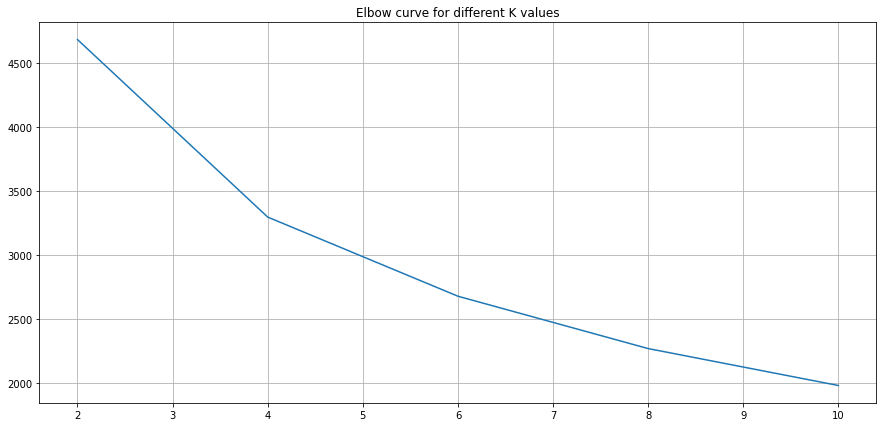

In [ ]:
fig = plt.figure(figsize = (15, 7))
plt.plot(n_clusters, kmeans_inertias)
plt.title('Elbow curve for different K values')
plt.grid(True)
plt.show()

For n_clusters = 2 , the average silhouette score is : 0.3920727361062658
For n_clusters = 4 , the average silhouette score is : 0.3024051811756395
For n_clusters = 6 , the average silhouette score is : 0.2623867454406832
For n_clusters = 8 , the average silhouette score is : 0.23745067906402217
For n_clusters = 10 , the average silhouette score is : 0.26116096690730883


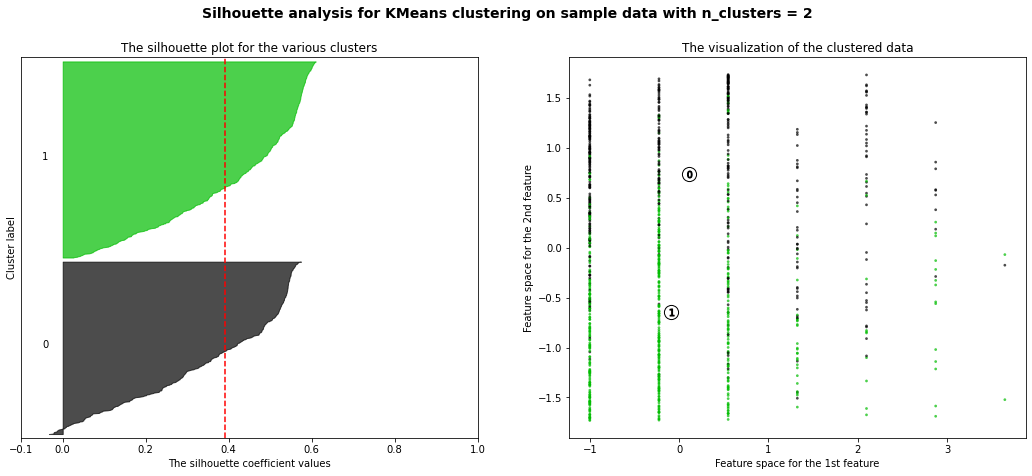

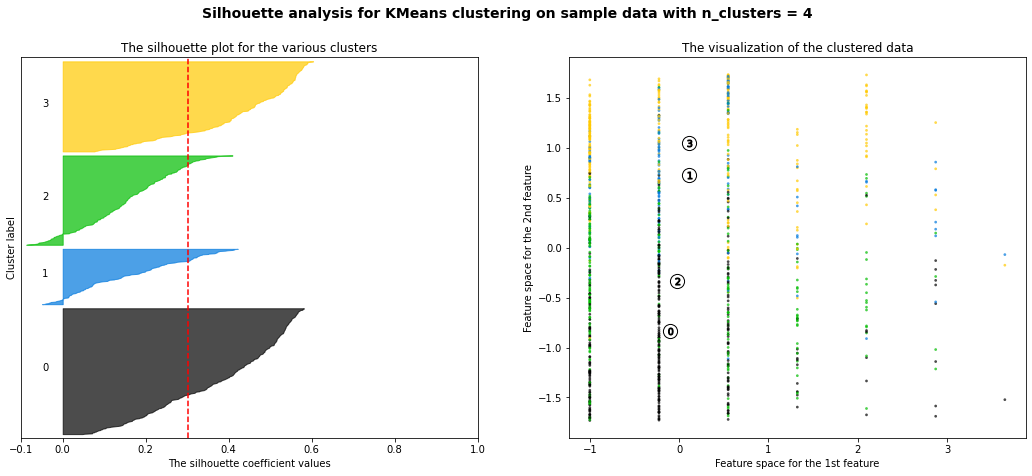

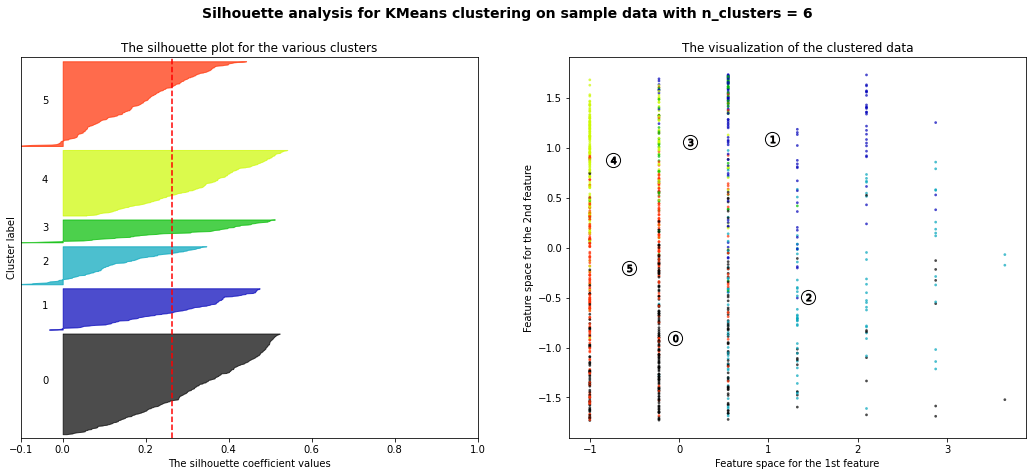

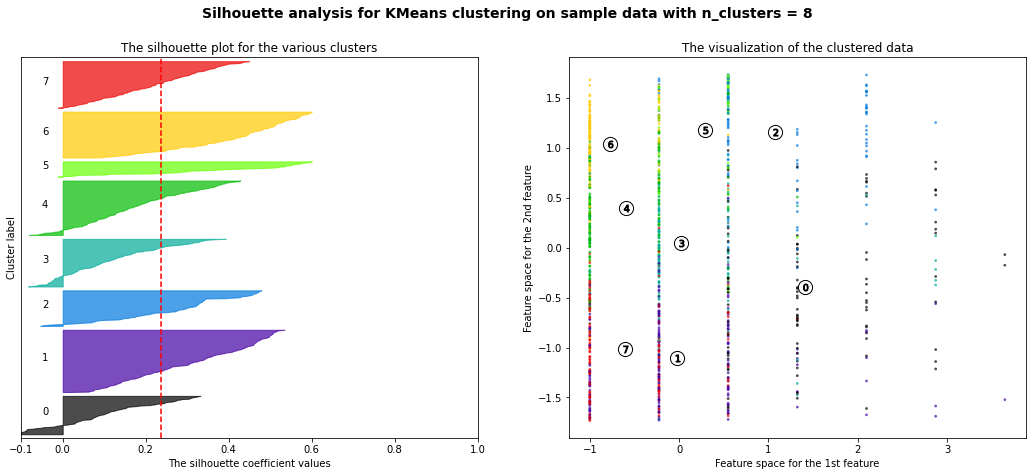

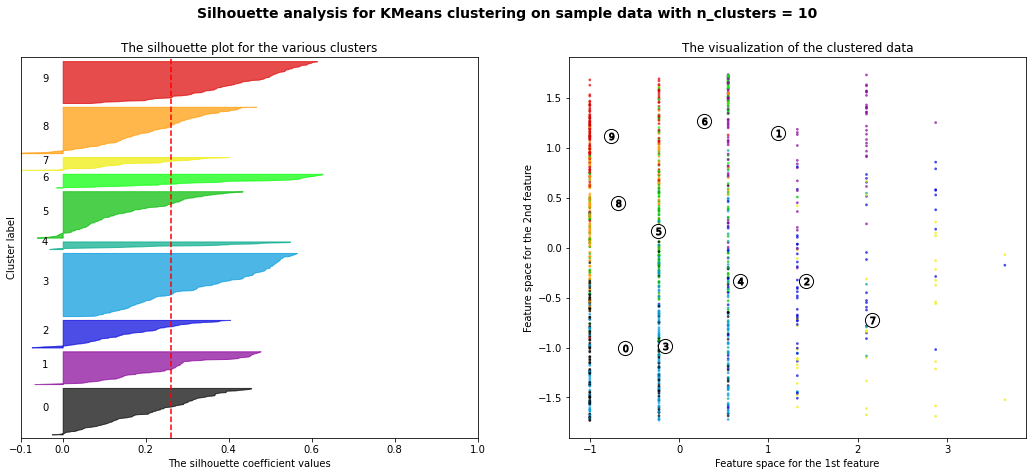

In [ ]:
plot_silhouette(X, n_clusters, random_state = 5)

Nuevamente, los métodos cuantitativos parecen tener importantes limitaciones para determinar el valor correcto de K.

## 5.5. Validación cualitativa

El objetivo de esta estrategia es verificar la distribución de las diferentes features utilizadas discriminadas por cluster. Por facilidad, se realizará la validación para K = 4.

In [ ]:
kmeans = KMeans(n_clusters = 4, random_state = 5)

In [ ]:
# Se almacenan los clusters asignados a cada instancia en el dataframe original para propósitos de visualización
df_companies['kmeans'] = kmeans.fit_predict(X)

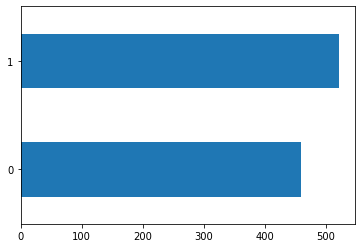

In [ ]:
df_companies['kmeans'].value_counts().sort_values().plot.barh()

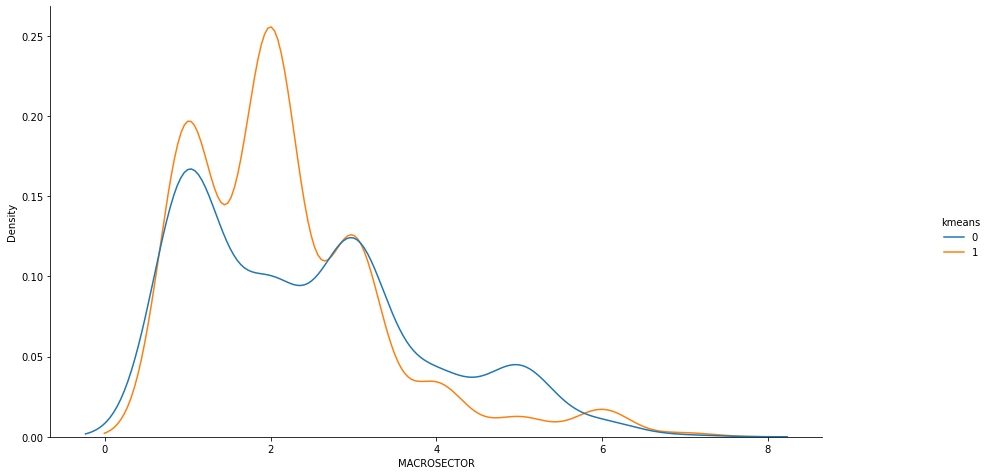

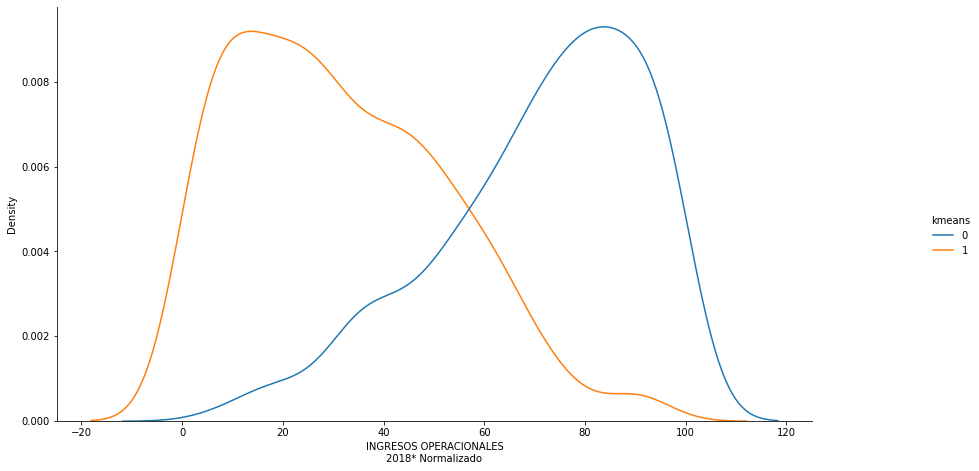

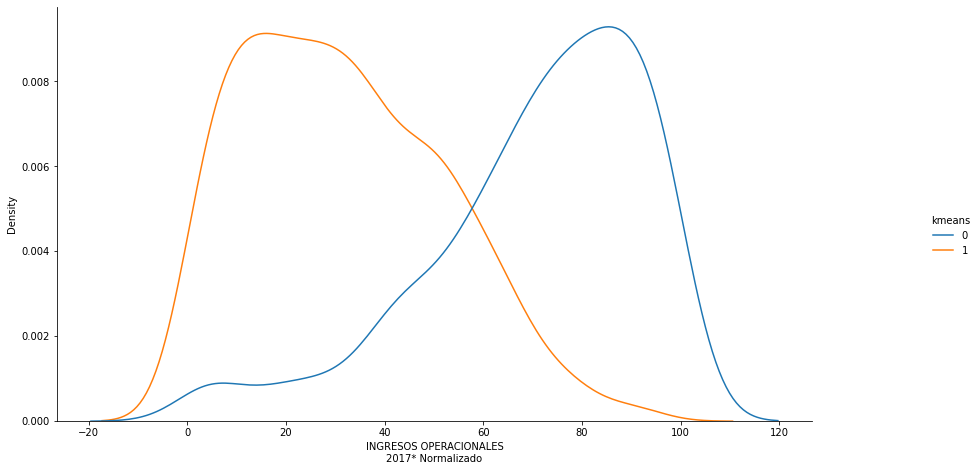

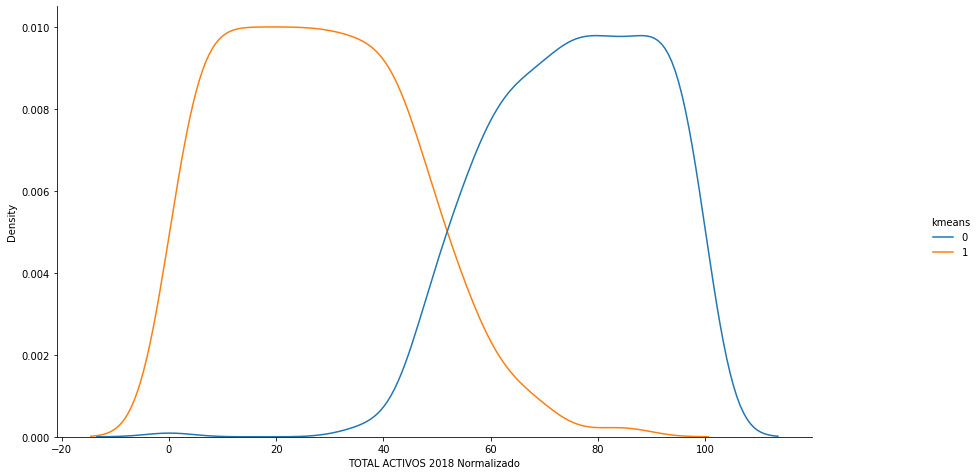

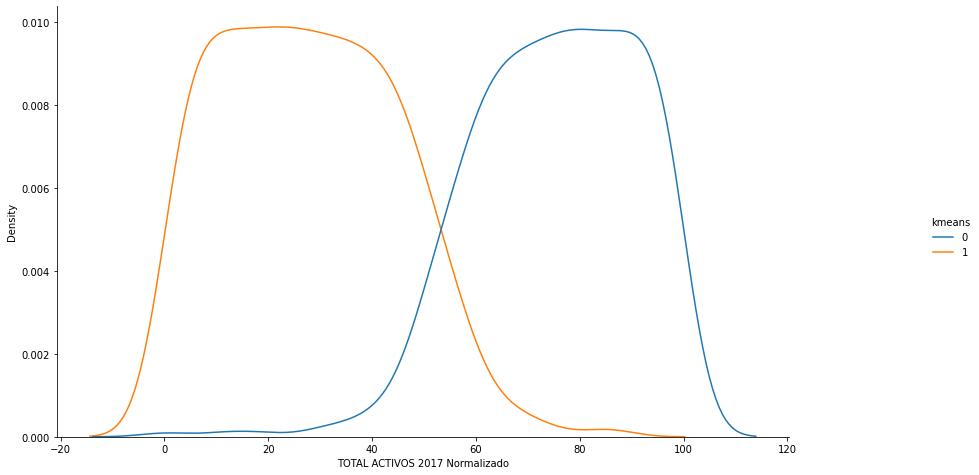

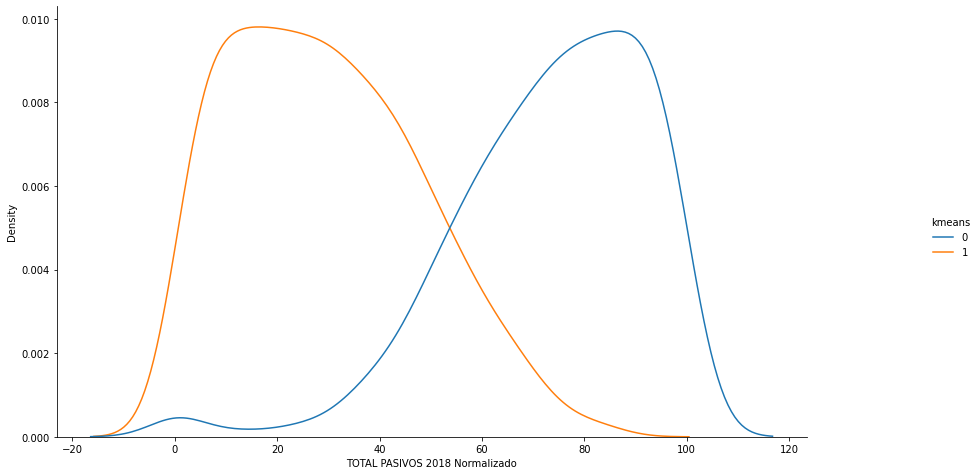

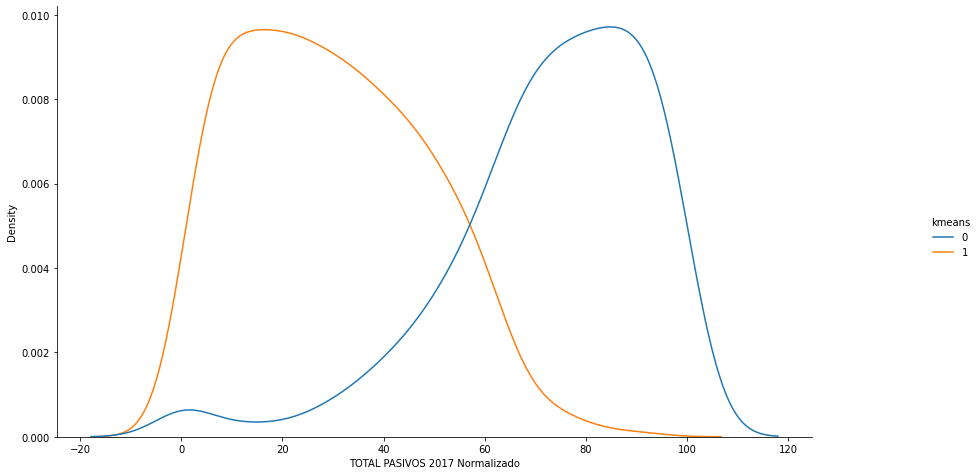

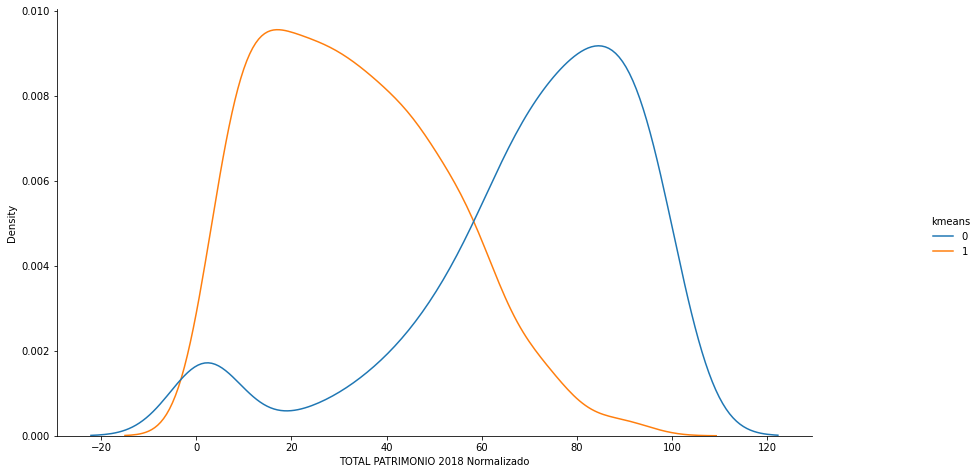

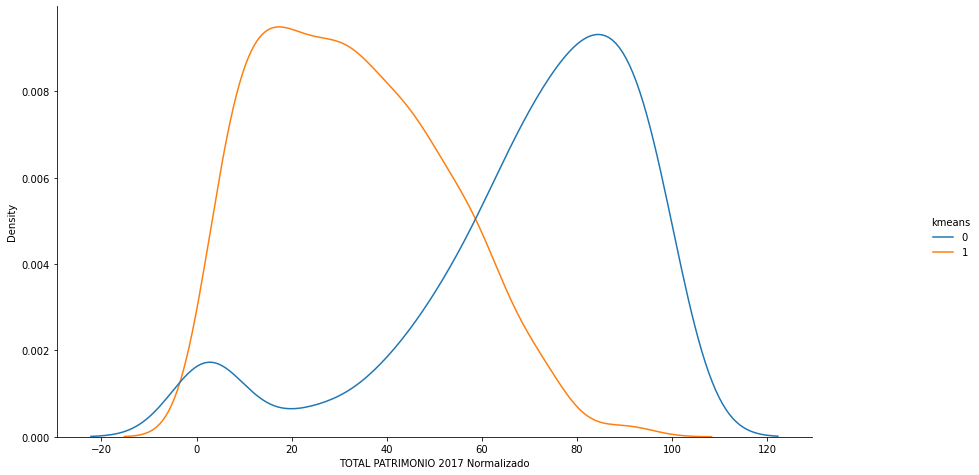

In [ ]:
cols = ['MACROSECTOR',
       'INGRESOS OPERACIONALES\n2018* Normalizado',
       'INGRESOS OPERACIONALES\n2017* Normalizado',
       'TOTAL ACTIVOS 2018 Normalizado', 'TOTAL ACTIVOS 2017 Normalizado',
       'TOTAL PASIVOS 2018 Normalizado', 'TOTAL PASIVOS 2017 Normalizado',
       'TOTAL PATRIMONIO 2018 Normalizado',
       'TOTAL PATRIMONIO 2017 Normalizado']

for col in cols:
  g = sns.displot(df_companies, x = col, hue = 'kmeans', kind = 'kde', palette = 'tab10')
  g.fig.set_size_inches(15, 7)